Notebook Testing

In [45]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports


In [46]:
#files = sorted(glob.glob("F:/SDI/sec17/*.fz"))  #filepath (windows formatted)
files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/sec32/*")) #filepath (mac os formatted).
print(len(files))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
try: #some datsets won't align, this is not ideal but we can skip alignment.
    aligned = [aa.register(i, data[0])[0] for i in data[0:]]
except:
    aligned = data
    print("DID NOT ALIGN")
template = np.mean(aligned, axis = 0) #mean template for calibration photometry --> average of sums == sum of averages in this case.
bkg_phot = sep.Background(template) #background subtract for source extraction.
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image

w = WCS(hdus[0][1].header) #WCS matrix object

99


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


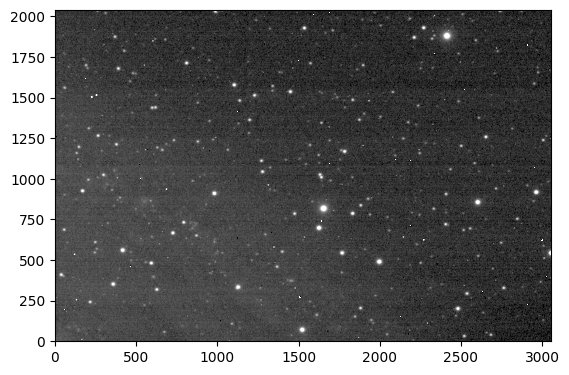

In [47]:
plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 75), origin = "lower") #plots template
plt.show()

In [48]:
references = [] #list for reference sources
mags = [] #reference magnitudes
for src in extracted_phot: #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs') #gives wcs transformation for pixel coordinates
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_g', 'psfMagErr_g'], radius = 15 * u.arcsec, region = False) #narrow field cone search to find source based on ra, dec.
    if search: #if SDSS query returned results, continue
        if search['psfMag_g'] < 16 and search['type'] == 'STAR': #filters search results by sources that are brighter than magnitude 16, and of type star.
            ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], g_mag = search['psfMag_g'], g_mag_err = search['psfMagErr_g']) #creates dictionary item with source position (ra, dec, x, y), source extent, and mags and errors as reported by SDSS.
            references.append(ref)

for ref in references: #aperture photometry for calibration model.
        coords = [ref['x_coord'], ref['y_coord']] #coordinate objects to make apertures.
        pcoords = PixCoord(ref['x_coord'], ref['y_coord'])
        radius_i = (ref['x_max'] - ref['x_min']) / 2 #inner radius
        radius_o_0 = radius_i + 5 #first outer radius
        radius_o_1 = radius_o_0 + 5 #second outer radius

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(template) #gets data of source

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1) #makes annulus region
        background_mean = ApertureStats(template, background_annulus).mean

        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix)

        inst_mag = -2.5 * np.log10(source_flux_total) #uncalibrated instrumental magnitude.
        mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['g_mag']), sky_err = float(ref['g_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
        mags.append(mag_cat)

first try: [ 0.65055798 20.65189767]
second try: [ 0.76932885 21.56909589]


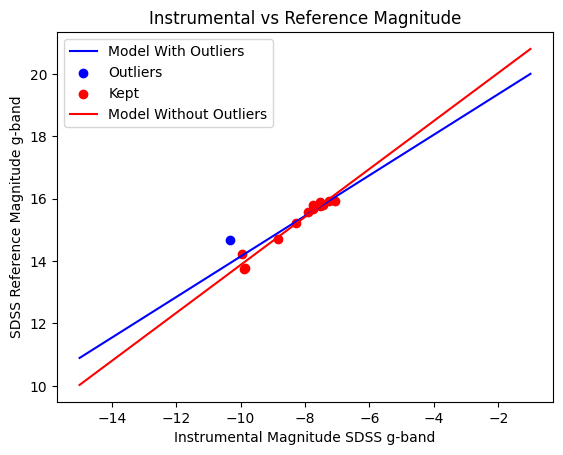

In [49]:
inst_mags = [mag['inst_mag'] for mag in mags]
sky_mags = [mag['sky_mag'] for mag in mags]
res = []


#Makes linear model for calibration:
#This is the first round of modeling, with outliers.
p0 = np.polyfit(inst_mags, sky_mags, deg = 1)
x = np.arange(-15, 0)
y = p0[0]*x + p0[1]
plt.plot(x, y, color = 'b', label = "Model With Outliers")
diffs = [s['sky_mag']- (s['inst_mag']*p0[0] + p0[1]) for s in mags]
stdv = np.std(diffs)

inst_mags_final = []
sky_mags_final = []
outlier_inst =[]
outlier_sky =[]

for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
    if diff < stdv:
        i = diffs.index(diff)
        inst_mags_final.append(inst_mags[i])
        sky_mags_final.append(sky_mags[i])
    else:
        i = diffs.index(diff)
        outlier_inst.append(inst_mags[i])
        outlier_sky.append(sky_mags[i])
p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1) #recalculates calibration model without outliers.
#p2 = np.polyfit(inst_mags_final, sky_mags_final, deg = 0)
#print(p2[0])
print("first try: {}".format(p0)) #prints slopes of each model. In theory, they should come out to around 1.
print("second try: {}".format(p1))


plt.scatter(outlier_inst, outlier_sky, color = 'b', label = "Outliers")
plt.scatter(inst_mags_final, sky_mags_final, color = 'r', label = "Kept")
plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers")
#plt.plot(x, [i+ p2[0] for i in x], color = 'g', label = "unity")
plt.xlabel("Instrumental Magnitude SDSS g-band")
plt.ylabel("SDSS Reference Magnitude g-band")
plt.title("Instrumental vs Reference Magnitude")
plt.legend()
#plt.savefig("F:/SDI/Section32Figures/calibrationplot.png", dpi = 1000)
plt.show()



In [50]:
#e = 1 #Telescope efficiency, taken to be .5 for now BUT ASK ABOUT IT
#Q_e = 1 #quantum efficency of SBIG STL 6303 cameras used at LCO .4m telescopes
#A = 1250 #.4m diameter telescope area in cm^2. Way to not hardcode telescope area?
#A_e = A*e*Q_e
#i_DC = hdus[i][1].header["DARKCURR"] #dark current reported in header
#t = hdus[i][1].header["EXPTIME"] #actual exposure time
#Omega = hdus[i][1].header["PIXSCALE"]
#print(N_r, i_DC, t, Omega)

In [ ]:

mags_final = []
for i, image in enumerate(aligned):
    print(i)
    N_r = hdus[i][1].header["RDNOISE"] #readout noise
    for c, source in enumerate(extracted_phot):
        coords = [source['x'], source['y']]
        pcoords = PixCoord(source['x'], source['y'])
        radius_i = (source['xmax'] - source['xmin']) / 2
        radius_o_0 = radius_i + 5
        radius_o_1 = radius_o_0 + 5

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(image) #gets data of source

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
        background_mean = ApertureStats(image, background_annulus).mean

        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix)

        readout_sum_square = np.sum(source_circle*np.float64(N_r**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

        delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(image, background_annulus)['aperture_sum'][0]))**(1/2) #this is the stuff for SNR

        if source_flux_total <= 0:
            inst_mag = -2.5*np.log10(abs(source_flux_total)) # For now, the case where the background is oversubtracted from LCO is handled in this way but this is probably not the correct way to do this.
            mag_coor = p1[0] * inst_mag + p1[1]
            delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
        else:
            inst_mag = -2.5*np.log10(source_flux_total)
            mag_coor = p1[0] * inst_mag + p1[1]
            delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
        border = False
        if abs(source['x'] - 3054) < 75 or abs(0-source['x']) < 75 and abs(source['y'] - 2042) <75 or abs(0 - source['y']) < 75:
            border = True

        info = dict(source_id = c, corrected_mag = mag_coor, mag_error = delta_m, x = source['x'], y = source['y'], b = border)
        mags_final.append(info)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [ ]:
#this is just for plotting.

c = 0
x_b = data[0].shape[1]
y_b = data[0].shape[0]
print(len(extracted_phot))
while c != len(extracted_phot):
    Mags = []
    Chis = []
    for mag in mags_final:
        if mag['source_id'] == c:
            Mags.append(mag)
    r = np.arange(0, len(Mags), 1)
    plt.errorbar(r, [m['corrected_mag'] for m in Mags], yerr= [m['mag_error'] for m in Mags] , linestyle = 'none', marker = 'o', color = 'b')
    if abs(x_b - Mags[0]['x']) < 50 or abs(0-Mags[0]['x']) < 50:
        if abs(y_b - Mags[0]['y']) < 50 or abs(0-Mags[0]['y']) < 50:
            print("Border Warning")

    avg_mag = np.mean([m['corrected_mag'] for m in Mags])
    for m in Mags:
        chi_i = ((m['corrected_mag'] - avg_mag)**2)/(np.std([m['corrected_mag'] for m in Mags]))
        Chis.append(chi_i)
    dof = len(Mags) - 1
    chi_dof = np.sum(Chis)/dof




    plt.title("Source Number: {}, Chi2 = {}".format(c, chi_dof))
    plt.xlabel('Frame Number')
    plt.ylabel("Magnitude, SDSS g-band")
    #plt.xticks(np.linspace(0, 99, 1))

    #plt.ylim(0, 25)
    #plt.figure(dpi=300)
    #plt.savefig("F:/SDI/Section17Figures/Source{}lightcurve.png".format(c), format = 'png', dpi = 500)
    plt.show()


    plt.title("Source Number: {}".format(c))
    plt.scatter(Mags[0]['x'], Mags[0]['y'], facecolors = 'none', edgecolors = 'r')
    plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')

    #plt.figure(dpi=300)
    #plt.savefig("F:/SDI/Section17Figures/Source{}location.png".format(c), format = 'png', dpi = 500)
    c +=1
    plt.show()


"""
i = 0
c = 0
while c != len(extracted_phot):
    for mag in mags_final:
        if mag['source_id'] == c:
            plt.scatter(i, mag['corrected_mag'], color = 'b')
            plt.title("Source Position: {}, {}".format(mag['x'],mag['y']))
            if mag['corrected_mag'] > 20:
                print(mag['x'], mag['y'])
            i += 1
    c += 1
    plt.show()
"""

''

In [ ]:
print(data[0].shape[1])

In [ ]:
plt.imshow(template, cmap= "viridis", norm= LogNorm(vmin=1, vmax = 60))
for source in extracted_phot:
    plt.scatter(source['x'], source['y'], facecolors = 'none', edgecolors = 'r')

plt.savefig("F:/SDI/template.png", dpi = 400)
